In [ ]:
pip install google-api-python-client

In [ ]:
pip install apiclient

  Preparing metadata (setup.py) ... done
  Created wheel for apiclient: filename=apiclient-1.0.4-py3-none-any.whl size=5195 sha256=684ad9f2d065b8aa143c1b132f3969ad4b56abada8d4416539621e035d733bee
  Stored in directory: /root/.cache/pip/wheels/9b/08/37/e058c64cfe64d1e24408246af36d7fe2bad9bac21a8b0959fa
Successfully built apiclient


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Youtube Video') #change to your location

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import libraries
%matplotlib inline
from googleapiclient.discovery import build
import requests
from datetime import datetime, timedelta

In [ ]:
import pandas as pd
from googleapiclient.discovery import build
import time
from google.colab import userdata
DEVELOPER_KEY= userdata.get('YouTubeKey')

# arguments to be passed to build function
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

# create youtube resource object for interacting with API
youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,
                    developerKey=DEVELOPER_KEY)

# **Mine YouTube by Keywords**

In [ ]:
import time
import pandas as pd

mo='06'

def get_videos_from_page(published_after, published_before, order_method="date", max_pages=50):
    all_videos = []
    next_page_token = None

    for _ in range(max_pages):
        try:
          search_response = youtube.search().list(
              part="snippet",
              q="gameplay walkthrough -music -coding",
              type="video",
              order=order_method,  # 改变排序方式
              videoDuration='medium', #时长
              publishedAfter=published_after,
              publishedBefore=published_before,
              maxResults=50,
              pageToken=next_page_token
          ).execute()

          all_results = search_response.get("items", [])
          video_ids = [item['id']['videoId'] for item in all_results]
          next_page_token = search_response.get("nextPageToken", None)

          if not video_ids:
              break

          video_response = youtube.videos().list(
              part="snippet,statistics",
              id=",".join(video_ids)
          ).execute()

          for video in video_response.get('items', []):
              title = video['snippet']['title']
              video_id = video['id']
              description = video['snippet'].get('description', "").replace("\n", " ")
              published_at = video['snippet']['publishedAt'][:10]
              video_url = f"https://www.youtube.com/watch?v={video_id}"
              view_count = int(video['statistics'].get('viewCount', 0))

              all_videos.append([title, description, published_at, view_count, video_url])

          print(f"[{order_method}] Fetched {len(all_results)} videos, nextPageToken: {next_page_token}")
          if not next_page_token:
              break

          time.sleep(2)

        except Exception as e:
          print(f"Error: {e}")
    df = pd.DataFrame(all_videos, columns=["Title", "Description", "Published Date", "Views", "URL"])
    return df.sort_values(by="Published Date", ascending=False)


# **按 3 天为单位抓取数据，并用不同 order 排序**
final_df = pd.DataFrame(columns=["Title", "Description", "Published Date", "Views", "URL"])
date_ranges = [
    (f"2024-{mo}-01", f"2024-{mo}-03"),
    (f"2024-{mo}-04", f"2024-{mo}-06"),
    (f"2024-{mo}-07", f"2024-{mo}-09"),
    (f"2024-{mo}-10", f"2024-{mo}-12"),
    (f"2024-{mo}-13", f"2024-{mo}-15"),
    (f"2024-{mo}-16", f"2024-{mo}-18"),
    (f"2024-{mo}-19", f"2024-{mo}-21"),
    (f"2024-{mo}-22", f"2024-{mo}-24"),
    (f"2024-{mo}-25", f"2024-{mo}-27"),
    (f"2024-{mo}-28", f"2024-{mo}-30"),   # 每个月最后一天不一样
]

# 3 种 order 方式
order_methods = ["date", "relevance", "rating"]

for start_date, end_date in date_ranges:
    for order in order_methods:
        published_after = f"{start_date}T00:00:00Z"
        published_before = f"{end_date}T23:59:59Z"
        print(f"Fetching videos from {start_date} to {end_date} using order: {order}...")

        df_videos = get_videos_from_page(published_after, published_before, order_method=order, max_pages=10)
        final_df = pd.concat([final_df, df_videos], ignore_index=True)

# **去重**
final_df = final_df.drop_duplicates(subset=["URL"])

# **保存最终数据**
final_df.to_csv(f"youtube_videos_M_{mo}_2024.csv", mode='a', header=False, index=False)
print(f"数据获取完成！共爬取 {len(final_df)} 条数据（去重后）")


Fetching videos from 2024-06-01 to 2024-06-03 using order: date...
[date] Fetched 32 videos, nextPageToken: None
Fetching videos from 2024-06-01 to 2024-06-03 using order: relevance...
[relevance] Fetched 38 videos, nextPageToken: None
Fetching videos from 2024-06-01 to 2024-06-03 using order: rating...
[rating] Fetched 32 videos, nextPageToken: None
Fetching videos from 2024-06-04 to 2024-06-06 using order: date...
[date] Fetched 38 videos, nextPageToken: None
Fetching videos from 2024-06-04 to 2024-06-06 using order: relevance...
[relevance] Fetched 45 videos, nextPageToken: None
Fetching videos from 2024-06-04 to 2024-06-06 using order: rating...
[rating] Fetched 38 videos, nextPageToken: None
Fetching videos from 2024-06-07 to 2024-06-09 using order: date...
[date] Fetched 30 videos, nextPageToken: None
Fetching videos from 2024-06-07 to 2024-06-09 using order: relevance...
[relevance] Fetched 34 videos, nextPageToken: None
Fetching videos from 2024-06-07 to 2024-06-09 using order:

# **Data Processing**

In [ ]:
import pandas as pd

all_df = pd.read_excel('YT_all.xls')
all_df = all_df.iloc[:, :5]
all_df = all_df.dropna()

In [ ]:
all_df.to_csv('YT_all_clean.csv', index=False)

# **BURT Model**

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
#import BERTopic
from bertopic import BERTopic

#bring in libraries with different purposes

# Data processing
import pandas as pd
import numpy as np

# Text preprocessiong
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

# Topic model
from bertopic import BERTopic

# Dimension reduction
from umap import UMAP

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
Example = pd.read_csv('YT_all_clean.csv', encoding='latin1')
Example['Information'] = Example['Title'].astype(str) + ' ' + Example['Description'].astype(str)
train_sample = Example[['Information']].sample(frac=0.8, random_state=42)

In [ ]:
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
print(f'There are {len(stopwords)} default stopwords. They are {stopwords}')

train_sample['Message_without_stopwords'] = train_sample['Information'].apply(lambda x: ' '.join([w for w in x.split() if w.lower() not in stopwords]))

# Lemmatization
train_sample['Message_lemmatized'] = train_sample['Message_without_stopwords'].apply(lambda x: ' '.join([wn.lemmatize(w) for w in x.split() if w not in stopwords]))

# Take a look at the data
train_sample.head()

There are 198 default stopwords. They are ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own',

,Information,Message_without_stopwords,Message_lemmatized
879,War of Rafts: Crazy Sea Battle - Gameplay Walk...,War Rafts: Crazy Sea Battle - Gameplay Walkthr...,War Rafts: Crazy Sea Battle - Gameplay Walkthr...
1988,Super Bear Adventure - Gameplay Walkthrough Pa...,Super Bear Adventure - Gameplay Walkthrough Pa...,Super Bear Adventure - Gameplay Walkthrough Pa...
889,IT BURNS - Galaxy S24 Ultra gaming SAMSUNG Gal...,BURNS - Galaxy S24 Ultra gaming SAMSUNG Galaxy...,BURNS - Galaxy S24 Ultra gaming SAMSUNG Galaxy...
912,Ben 10 - Omnitrix Hero Gameplay Walkthrough | ...,Ben 10 - Omnitrix Hero Gameplay Walkthrough | ...,Ben 10 - Omnitrix Hero Gameplay Walkthrough | ...
1596,NEW UPDATE 11.0.1 Super Bear Adventure Gamepla...,NEW UPDATE 11.0.1 Super Bear Adventure Gamepla...,NEW UPDATE 11.0.1 Super Bear Adventure Gamepla...


Predefined Topics. I used predefined topics because if I use the method of "find as many as you can" it will result in too many topics based on different video structures and types, instead of solely based on the game genres.

In [ ]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

In [ ]:
zeroshot_topic_list = [
    "Role-playing game (RPG)",
    "Action game",
    "Adventure game",
    "Shooter game (FPS/TPS)",
    "Simulation game",
    "Strategy game",
    "Sports and Racing game",
    "Music and Dance game",
    "Survival game",
    "Card game",
    "Horror game",
    "Multiplayer Online game",
    "Sandbox game",
    "Puzzle game"
]

In [ ]:
topic_model = BERTopic(
    embedding_model="thenlper/gte-small",
    min_topic_size=15,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.85,
    representation_model=KeyBERTInspired()
)
topics, probs = topic_model.fit_transform(train_sample.Message_lemmatized)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,452,-1_commander_gameplay_army_game,"[commander, gameplay, army, game, games, walkt...",[Army Commander - Gameplay Walkthrough Part 47...
1,0,2,Role-playing game (RPG),"[summoners, mmorpg, summoner, rpg, dungeon, ga...",[Raziel Rebirth: Dungeon Raid - English Beta G...
2,1,163,Action game,"[gameplay, games, stickman, game, walkthrough,...",[Army Commander War - Gameplay Walkthrough Par...
3,2,230,Adventure game,"[rexblaxgaming2, gameplay, walkthrough, platfo...",[NEW UPDATE 11.0.0 Super Bear Adventure Gamepl...
4,3,11,Shooter game (FPS/TPS),"[gameplay, shooter, sniper, fps, games, game, ...",[POLYWAR - Gameplay Walkthrough Part 44 - NEW ...
5,4,26,Simulation game,"[gameplay, game, simulator, simulation, sim, w...",[Pizza Ready! Gameplay Walkthrough Part 2 - Tu...
6,5,12,Strategy game,"[gameplay, warfare, games, game, war, pocketga...",[Fight America: Country War Gameplay Walkthrou...
7,6,34,Sports and Racing game,"[kart, racers, racer, nickelodeon, racing, gam...",[Nickelodeon Kart Racers 3 - Characters Stages...
8,7,41,Survival game,"[gameplay, walkthrough, games, game, zombies, ...",[Wasteland Life - Gameplay Walkthrough Part 2 ...
9,8,2,Card game,"[nfl2kcardbattler, roguelike, cards, poker, ca...",[Balatro Beginner's Guide - Tips Tricks Tutori...


In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_term_rank()

In [ ]:
# Visualize intertopic distance
topic_model.visualize_topics()

In [ ]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
map=topic_model.visualize_heatmap()

In [ ]:
# get similarity matrix from hitmap
similarity_matrix = map['data'][0]['z']

import pandas as pd
correlation_df = pd.DataFrame(similarity_matrix)

# 处理相关性系数，查看相关性大于0.92的主题对
topics_to_merge = []
for i in range(12, similarity_matrix.shape[0]):  # 从Topic 13开始
    # 找到与前12个Topic最相关的一个
    most_correlated_topic_index = correlation_df.iloc[i, :12].idxmax()  # 获取最相关的前12个Topic
    max_correlation_value = correlation_df.iloc[i, :12].max()

    # 如果相关性系数大于等于0.92，合并这些主题
    if max_correlation_value >= 0.92:
        topics_to_merge.append([i, most_correlated_topic_index])

# 输出需要合并的主题对
print("\nTopics to merge:")
for topic_to_merge in topics_to_merge:
    print(f"Topic {topic_to_merge[0]} can be merged with Topic {topic_to_merge[1]} with correlation coefficient {similarity_matrix[topic_to_merge[0], topic_to_merge[1]]}")


In [ ]:
print(topics_to_merge)

[[12, 9], [14, 1], [16, 1], [17, 2], [18, 2], [19, 4], [21, 9], [22, 11], [23, 1], [24, 9], [25, 9], [26, 9], [27, 1], [29, 4], [30, 1], [31, 1], [32, 1], [33, 4], [34, 1], [35, 1], [36, 1], [37, 11], [38, 1]]


In [ ]:
# 合并所有包含1-13的主题对，并且每个主题对内的元素从大到小排列
merged_topics_to_merge = []

# 用一个字典来跟踪每个主题的所有合并对
merged_sets = {}

for pair in topics_to_merge:
    # 检查是否包含1到13之间的主题
    if any(topic in range(1, 14) for topic in pair):
        # 排序该主题对，确保从大到小
        sorted_pair = tuple(sorted(pair, reverse=True))

        # 找到或创建相关的集合，并合并主题
        found = False
        for key in list(merged_sets.keys()):
            if sorted_pair[1] in merged_sets[key]:
                merged_sets[key].update(sorted_pair)
                found = True
                break
        if not found:
            merged_sets[sorted_pair[0]] = set(sorted_pair)

# 将每个合并后的集合转换为列表并排序
for merged_set in merged_sets.values():
    merged_topics_to_merge.append(sorted(list(merged_set), reverse=True))

# 输出合并后的列表
print("Merged Topics to Merge (with Topics 1-13):")
print(merged_topics_to_merge)


Merged Topics to Merge (with Topics 1-13):
[[26, 25, 24, 21, 12, 9], [38, 36, 35, 34, 32, 31, 30, 27, 23, 16, 14, 1], [18, 17, 2], [33, 29, 19, 4], [37, 22, 11]]


In [ ]:
# Topic to merge
topics_to_merge = merged_topics_to_merge
#we merged topic 3 and topic 4 together
# Merge topics
topic_model.merge_topics(train_sample['Message_lemmatized'], topics_to_merge)

# Get the list of topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,452,-1_gameplay_walkthrough_game_games,"[gameplay, walkthrough, game, games, commander...",[Army Commander - Gameplay Walkthrough Part 40...
1,0,2,Role-playing game (RPG),"[summoners, mmorpg, gameplay, summoner, rpg, d...",[Raziel Rebirth: Dungeon Raid - English Beta G...
2,3,11,3_gameplay_shooter_sniper_fps,"[gameplay, shooter, sniper, fps, games, game, ...",[POLYWAR - Gameplay Walkthrough Part 44 - NEW ...
3,5,12,Strategy game,"[gameplay, warfare, games, game, war, pocketga...",[Fight America: Country War Gameplay Walkthrou...
4,6,34,Sports and Racing game,"[kart, racers, racer, nickelodeon, racing, gam...",[Nickelodeon Kart Racers 3 - Characters Stages...
5,7,41,7_gameplay_walkthrough_games_game,"[gameplay, walkthrough, games, game, zombies, ...",[Wasteland Life - Gameplay Walkthrough Part 2 ...
6,8,2,Card game,"[nfl2kcardbattler, game, roguelike, cards, pok...",[Balatro Beginner's Guide - Tips Tricks Tutori...
7,10,12,Multiplayer Online game,"[multiplayerparkour, craftworldmultiplayer, mu...",[Multiplayer Parkour Craft World 2024 Gameplay...
8,13,22,13_smaghetti_smb3_nintendo_sma4,"[smaghetti, smb3, nintendo, sma4, gameboyadvan...",[SMAGHETTI | SMA4: SMB3 CUSTOM LEVELS #1595 ==...
9,15,19,15_drawingvideos_drawinganime_sketchinganime_d...,"[drawingvideos, drawinganime, sketchinganime, ...",[Art Drawing | draw drawing video drawing vide...


In [ ]:
topic_model.save("YT_model")

# Load the topic model
my_model = BERTopic.load("YT_model")

2025-03-24 22:22:43,025 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
Example['Topic'] = my_model.transform(Example['Information'])[0]

In [ ]:
Example.to_csv('YT_all_topic.csv', index=False)

# **Find Game Genre**

In [ ]:
df=pd.read_csv('YT_all_topic.csv')


In [ ]:
# Modify the function to handle mixed date formats and use week-based grouping

def calculate_weekly_trend_summary(df, date_col="Published Date", view_col="View", topic_col="Topic"):
    # Handle mixed date formats using 'mixed' option
    df[date_col] = pd.to_datetime(df[date_col], format='mixed', errors='coerce')
    df = df.dropna(subset=[date_col])  # Drop rows with invalid dates

    # Create a 'Week' column representing the start of the week for each date
    df['Week'] = df[date_col].apply(lambda x: x - pd.Timedelta(days=x.weekday()))

    # Identify the last two weeks
    latest_week = df['Week'].max()
    previous_week = latest_week - pd.Timedelta(weeks=1)

    # Filter for each of the two weeks
    week1_mask = df['Week'] == previous_week
    week2_mask = df['Week'] == latest_week

    # Aggregate view counts by topic for the two weeks
    week1_views = df[week1_mask].groupby(topic_col)[view_col].sum().rename("Week1_Views")
    week2_views = df[week2_mask].groupby(topic_col)[view_col].sum().rename("Week2_Views")

    # Merge and calculate percentage change
    trend_df = pd.concat([week1_views, week2_views], axis=1).fillna(0)
    trend_df["Change (%)"] = ((trend_df["Week2_Views"] - trend_df["Week1_Views"]) / trend_df["Week1_Views"].replace(0, 1)) * 100

    # Define trend status
    def classify_status(change):
        if change > 50:
            return "Rising"
        elif change < -50:
            return "Falling"
        else:
            return "Stable"

    trend_df["Status"] = trend_df["Change (%)"].apply(classify_status)

    return trend_df.reset_index()

# Apply the modified function to the current DataFrame
trend_summary_weekly_df = calculate_weekly_trend_summary(df)
trend_summary_weekly_df


,Topic,Week1_Views,Week2_Views,Change (%),Status
0,-1,5860839.0,375608.0,-9.359122e+01,Falling
1,0,6519.0,0.0,-1.000000e+02,Falling
2,1,1528.0,18702.0,1.123953e+03,Rising
3,2,616.0,2915.0,3.732143e+02,Rising
4,3,7728.0,38160.0,3.937888e+02,Rising
5,4,52099.0,49200.0,-5.564406e+00,Stable
6,6,63777.0,9482.0,-8.513257e+01,Falling
7,9,109128.0,403661.0,2.698968e+02,Rising
8,10,3918.0,0.0,-1.000000e+02,Falling
9,11,925430.0,668671.0,-2.774483e+01,Stable


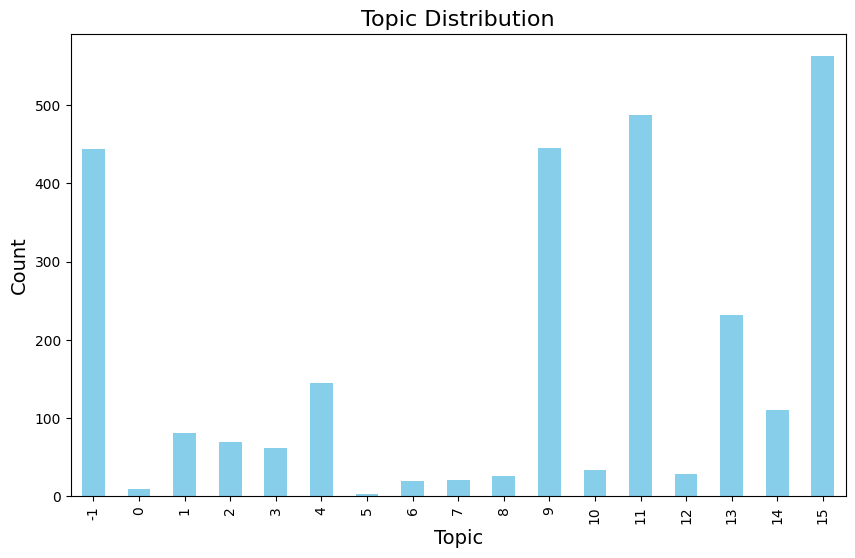

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 计算每个主题的出现次数
topic_counts = df['Topic'].value_counts()

# 按照主题编号排序
topic_counts = topic_counts.sort_index()

# 绘制条形图
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color='skyblue')

# 添加标题和标签
plt.title('Topic Distribution', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Count', fontsize=14)

# 调整 X 轴标签角度
plt.xticks(rotation=90)
plt.show()


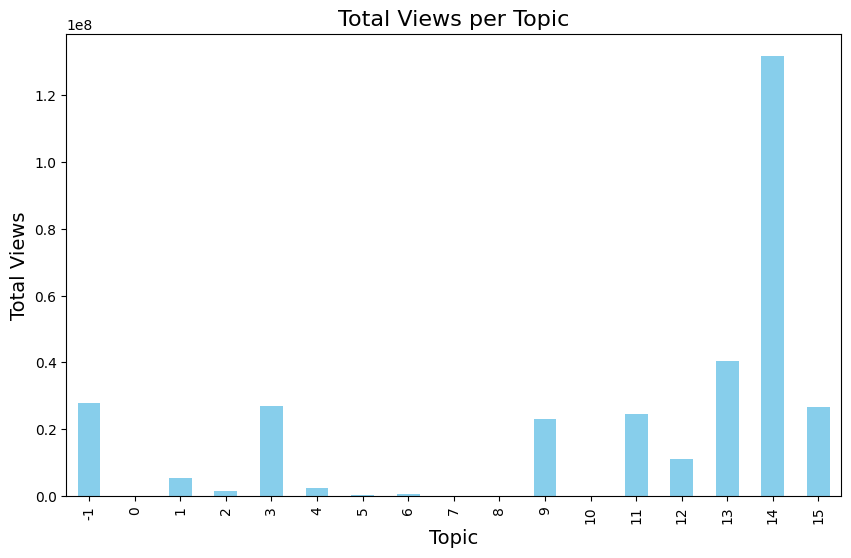

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 计算每个主题的总播放量
topic_view_counts = df.groupby('Topic')['View'].sum()

# 绘制条形图
plt.figure(figsize=(10, 6))
topic_view_counts.plot(kind='bar', color='skyblue')

# 添加标题和标签
plt.title('Total Views per Topic', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Total Views', fontsize=14)

# 调整 X 轴标签角度
plt.xticks(rotation=90)
plt.show()


In [ ]:
#transform datetime format
df.loc[:457, 'Published Date'] = pd.to_datetime(df['Published Date'], errors='coerce')
df.loc[458:, 'Published Date'] = pd.to_datetime(df.loc[458:, 'Published Date'], format='%Y/%m/%d %H:%M', errors='coerce')

In [ ]:
df.dropna(subset=['Published Date'], inplace=True)

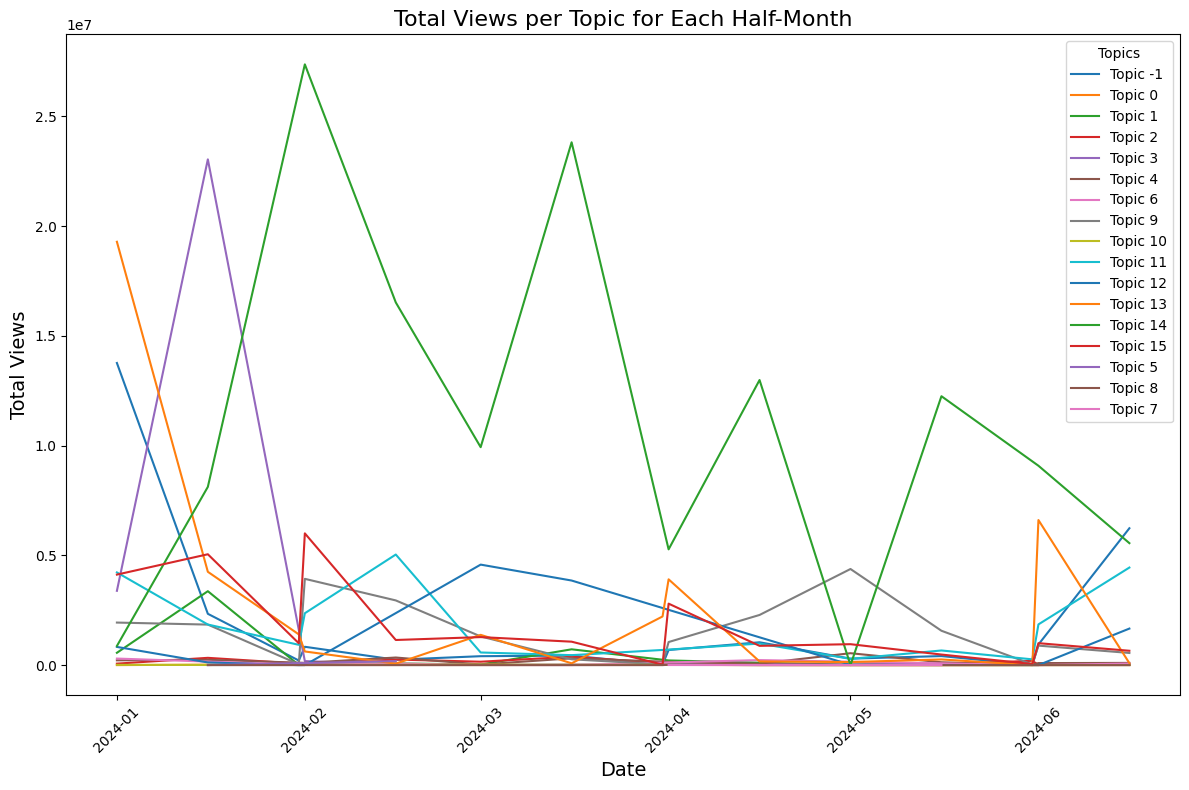

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 创建一个新的列，表示每个日期所属的半月（例如：1月1日到15日为第一个半月，16日到月底为第二个半月）
df['HalfMonth'] = df['Published Date'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=1) + pd.DateOffset(days=(x.day-1)//15 * 15))

# 按照 'HalfMonth' 和 'Topic' 分组，并计算每个分组的播放量总和
topic_play_counts = df.groupby(['HalfMonth', 'Topic'])['View'].sum().reset_index()

# 绘制折线图
plt.figure(figsize=(12, 8))

# 绘制每个主题的折线
for topic in topic_play_counts['Topic'].unique():
    topic_data = topic_play_counts[topic_play_counts['Topic'] == topic]
    plt.plot(topic_data['HalfMonth'], topic_data['View'], label=f'Topic {topic}')

# 添加标题和标签
plt.title('Total Views per Topic for Each Half-Month', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Views', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Topics')

# 显示图表
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# 确保 HalfMonth 和 View 是正确的数据类型
df['HalfMonth'] = pd.to_datetime(df['HalfMonth'])
df['View'] = pd.to_numeric(df['View'])

# 找出最后两个 HalfMonth
half_months = sorted(df['HalfMonth'].unique())
last_halfmonth = half_months[-1]
second_last_halfmonth = half_months[-2]

# 分别计算两个 HalfMonth 中每个 Topic 的总 View
view_last = df[df['HalfMonth'] == last_halfmonth].groupby('Topic')['View'].sum()
view_prev = df[df['HalfMonth'] == second_last_halfmonth].groupby('Topic')['View'].sum()

# 对齐两个 Series（有些 Topic 可能只在一个 halfmonth 出现）
view_diff = view_last.subtract(view_prev, fill_value=0)

# 找出增长最多的 Topic
top_topic = view_diff.idxmax()
summ = view_diff.sort_values(ascending=False)


In [ ]:
 summ

,View
Topic,
-1,5296580.0
11,2590109.0
12,1662775.0
6,70776.0
3,37157.0
4,8341.0
0,6519.0
10,160.0
8,147.0


In [ ]:
df.to_csv('YT_all_topic_date_new.csv', index=False)

From the analysis above, we can see that the most popular game type is Sandbox Game. So I would recommand our client to look into this type of game, since it has a more stable view compared to other types, meaning that in any given time it will be a safer investment option with less variance

For the newly emerging game genre, they are type 11 (horror game) and 12 (manualidades_youtube_audiencia_entrenamiento)

# **Sentiment Analysis**

In [ ]:
df=pd.read_csv('YT_all_topic_date_new.csv')
top_10_views_topic_14 = df[df['Topic'] == 14].nlargest(10, 'View')
top_10_views_topic_14

,Title,Description,Published Date,View,Link,Information,Topic,HalfMonth
1875,HOW I BECAME A MILLIONAIRE!!,"Today, we're opening up shops to earn tons is ...",2024-04-29 00:00:00,12869340,https://www.youtube.com/watch?v=G4opf4amUZ4,"HOW I BECAME A MILLIONAIRE!! Today, we're open...",14,2024-04-16
921,I Built a Whip that Crushes Bones,Instagram: https://www.instagram.com/mikeshake...,2024-02-28 00:00:00,12657174,https://www.youtube.com/watch?v=G63jjvibWmk,I Built a Whip that Crushes Bones Instagram: h...,14,2024-02-16
1300,1 vs 1 Billion Block Build in Minecraft!,A billion is such an UNIMAGINABLE number to me...,2024-03-23 00:00:00,12365283,https://www.youtube.com/watch?v=W0zZ3cG729s,1 vs 1 Billion Block Build in Minecraft! A bil...,14,2024-03-16
2267,WARDENS vs. The Most Secure House,"Today, we're in big trouble! An Ancient City h...",2024-05-25 00:00:00,11946472,https://www.youtube.com/watch?v=-7AhPzV6yi8,"WARDENS vs. The Most Secure House Today, we're...",14,2024-05-16
514,Level 1 to 100 Magic Tricks Anyone Can Do,These are level 1 to 100 magic tricks anyone c...,2024-02-03 00:00:00,11011358,https://www.youtube.com/watch?v=eGewFYQhJEQ,Level 1 to 100 Magic Tricks Anyone Can Do Thes...,14,2024-02-01
1257,"Minecraft, But Mining Is OVERPOWERED","Today, we're going mining with some overpowere...",2024-03-20 00:00:00,8210846,https://www.youtube.com/watch?v=z2N20UEvQ0A,"Minecraft, But Mining Is OVERPOWERED Today, we...",14,2024-03-16
664,Minecraft NOOB vs PRO: The Roulette of OP Weapons,"Today, we're playing PVP Roulette! Each of the...",2024-02-10 00:00:00,7891161,https://www.youtube.com/watch?v=2sC3tlVEMXM,Minecraft NOOB vs PRO: The Roulette of OP Weap...,14,2024-02-01
182,LEGO Vehicles vs All Terrain...,Check out Krazy Ky's Bricklink Store for your ...,2024-01-27 00:00:00,5922662,https://www.youtube.com/watch?v=tVtrHDNOCRM,LEGO Vehicles vs All Terrain... Check out Kraz...,14,2024-01-16
2447,Lava Rises Every Minute!,"Today, we've gotta hurry! Lava is quickly rais...",2024-06-09 00:00:00,5835950,https://www.youtube.com/watch?v=NDOwRuHt_Fo,"Lava Rises Every Minute! Today, we've gotta hu...",14,2024-06-01
565,SECRET TREE HOUSE You will Never Find!,"Today, we've having a house building competiti...",2024-02-05 00:00:00,5703913,https://www.youtube.com/watch?v=jOVd0ZSJzXo,"SECRET TREE HOUSE You will Never Find! Today, ...",14,2024-02-01


In the top 10 sandbox videos, 8 of them are about Minecraft. 1 is about Lego and another is about some real-world game. So we're pretty sure that Minecraft is the most popular sandbox game right now, even if it's a relatively old game (released in 2009). The reasons might be it's a game that can inspire people's creativity, so YT minecraft videos are always fun to watch. It also might be because Minecraft has been keeping on updating new features to retain players. In the next section, by analyzing the comments, we further explore how people view Minecraft, and want to explore why it's popular and fun to watch.

In [ ]:
df=pd.read_csv('YT_all_topic_date_new.csv')
top_10_views_topic_11 = df[df['Topic'] == 11].nlargest(10, 'View')
top_10_views_topic_11

,Title,Description,Published Date,View,Link,Information,Topic,HalfMonth
883,Overnight In The Real Conjuring House!,This was by far the scariest place I have ever...,2024-02-27 00:00:00,4133617,https://www.youtube.com/watch?v=5j9_Ilwdpfw,Overnight In The Real Conjuring House! This wa...,11,2024-02-16
2585,Home Alone Roblox,"Today, we've been left home alone! That means ...",2024-06-16 00:00:00,2774961,https://www.youtube.com/watch?v=stte9jaGWjM,"Home Alone Roblox Today, we've been left home ...",11,2024-06-16
438,Teke Teke Horror Gameplay,Teke Teke Horror Gameplay Like Aim: 17k #teket...,2024-01-07 00:00:00,1883981,https://www.youtube.com/watch?v=_cbqeOvh3pU,Teke Teke Horror Gameplay Teke Teke Horror Gam...,11,2024-01-01
2359,Help Out Story: Tricky Puzzle - Gameplay Walkt...,Help Out Story: Tricky Puzzle Pure Guide - Gam...,2024-06-02 00:00:00,1194613,https://www.youtube.com/watch?v=yNclpKz7SNA,Help Out Story: Tricky Puzzle - Gameplay Walkt...,11,2024-06-01
344,Ice Scream 8 Experiment - Outwitt Mod | Shiva ...,Ice Scream 8 Experiment - Outwitt Mod leke aay...,2024-01-15 00:00:00,1001156,https://www.youtube.com/watch?v=38izLvb606U,Ice Scream 8 Experiment - Outwitt Mod | Shiva ...,11,2024-01-01
685,ROBLOX - GREAT SCHOOL BREAKOUT! Gameplay Walkt...,ROBLOX - GREAT SCHOOL BREAKOUT! Gameplay Walkt...,2024-02-14 00:00:00,746240,https://www.youtube.com/watch?v=R0_G9AXkEmg,ROBLOX - GREAT SCHOOL BREAKOUT! Gameplay Walkt...,11,2024-02-01
494,Green Monster Life Challenge 4 - Gameplay Walk...,Green Monster Life Challenge 4 - Gameplay Walk...,2024-02-01 00:00:00,716160,https://www.youtube.com/watch?v=GYtOckVMNZo,Green Monster Life Challenge 4 - Gameplay Walk...,11,2024-02-01
356,Through the Wall (WEEGOON) - Funny Stickman - ...,Through the Wall (WEEGOON) - Funny Stickman - ...,2024-01-04 00:00:00,675237,https://www.youtube.com/watch?v=jJANVuwQhfM,Through the Wall (WEEGOON) - Funny Stickman - ...,11,2024-01-01
24,Help Me: Tricky Story - Part 1 All Level - Gam...,Help Me: Tricky Story - Part 1 All Level - Gam...,2024-01-28 00:00:00,643300,https://www.youtube.com/watch?v=Noow0PANBPk,Help Me: Tricky Story - Part 1 All Level - Gam...,11,2024-01-16
2565,SCHOOLBOY RUNAWAY STEALTH - ACT 1 ESCAPE FULL ...,SCHOOLBOY RUNAWAY STEALTH - ACT 1 ESCAPE FULL ...,2024-06-17 00:00:00,637420,https://www.youtube.com/watch?v=jlOO_GoLJwk,SCHOOLBOY RUNAWAY STEALTH - ACT 1 ESCAPE FULL ...,11,2024-06-16


In [ ]:
df=pd.read_csv('YT_all_topic_date_new.csv')
top_10_views_topic_12 = df[df['Topic'] == 12].nlargest(10, 'View')
top_10_views_topic_12

,Title,Description,Published Date,View,Link,Information,Topic,HalfMonth
977,??FUNDAS QUE PARECEN TORTAS? e?¡è¡§e??¡À,"Holaaaaa, vayan a seguirme en Instagram para e...",2024-03-03 00:00:00,4579606,https://www.youtube.com/watch?v=rFwv07Pprps,??FUNDAS QUE PARECEN TORTAS? e?¡è¡§e??¡À Holaa...,12,2024-03-01
1345,e???Mi Nueva Peligrosa Mascota Ataca Todo lo q...,e??¡äHabla con Bruno y Joel aqu?- : https://t....,2024-03-26 00:00:00,3853709,https://www.youtube.com/watch?v=om-DQP6QuaY,e???Mi Nueva Peligrosa Mascota Ataca Todo lo q...,12,2024-03-16
2718,A CADA BOUNTY EU USO UM NOVO ESTILO DE LUTA no...,Minha Loja - https://lojadolucao.com,2024-06-26 00:00:00,1664999,https://www.youtube.com/watch?v=7v4eMyBToAg,A CADA BOUNTY EU USO UM NOVO ESTILO DE LUTA no...,12,2024-06-16
203,DISEGNA QUESTO E NON TI ANNOIERAIe??¡Àa?¡è???t...,TUTORIAL DEI DISEGNI DA FARE QUANDO TI ANNOIe?...,2024-01-14 00:00:00,599068,https://www.youtube.com/watch?v=HDC4dxFv3hU,DISEGNA QUESTO E NON TI ANNOIERAIe??¡Àa?¡è???t...,12,2024-01-01
379,Jugu?? al Juego con Gr??ficos mas Realistas BO...,a??e???suscribete es gratis! e??? a??Z Drinks ...,2024-01-14 00:00:00,103011,https://www.youtube.com/watch?v=XZ9jMrcgnDA,Jugu?? al Juego con Gr??ficos mas Realistas BO...,12,2024-01-01
38,NASCITA DEL FIGLIO DI MOLLETTINOe???a?¡è???Com...,?? NATO IL FIGLIO DI MOLLETTINO E MOLLETTINAe?...,2024-01-10 00:00:00,100194,https://www.youtube.com/watch?v=9epThiJ0iPw,NASCITA DEL FIGLIO DI MOLLETTINOe???a?¡è???Com...,12,2024-01-01
189,Personalizza i GADGET di SCUOLA e fai colpo su...,PERSONALIZZO I GADGET DI SCUOLA A TEMA SAN VAL...,2024-01-28 00:00:00,84197,https://www.youtube.com/watch?v=_gkvIWuNtbY,Personalizza i GADGET di SCUOLA e fai colpo su...,12,2024-01-16
366,Rispondo alle vostre DOMANDEa?¡è???e?¡è-mi con...,RISPONDO ALLE VOSTRE DOMANDENDEe???a?? Finalme...,2024-01-18 00:00:00,26234,https://www.youtube.com/watch?v=TYtzqnfVg1M,Rispondo alle vostre DOMANDEa?¡è???e?¡è-mi con...,12,2024-01-16
432,PRIMEIRA GAMEPLAY JOGANDO HAWKED!! NOVO JOGO G...,Galera Se Liga S?3!! PRIMEIRA GAMEPLAY TESTAND...,2024-01-04 00:00:00,18321,https://www.youtube.com/watch?v=UDU7vFIaFW0,PRIMEIRA GAMEPLAY JOGANDO HAWKED!! NOVO JOGO G...,12,2024-01-01
2083,SEO YouTube: Aprende a mejorar la retenciÃ³n d...,En este vÃ­deo te enseÃ±o SEO Youtube Aprende ...,2024-05-13 00:00:00,15151,https://www.youtube.com/watch?v=_C7TBgnBbuE,SEO YouTube: Aprende a mejorar la retenciÃ³n d...,12,2024-05-01


# **Get Video Comments**

In [ ]:
import csv

def youtube_video_comments(video_id, max_results=10000, output_file='youtube_comments.csv'):
    comments = []
    next_page_token = None
    part = "id,snippet,replies"

    while len(comments) < max_results:
        response = youtube.commentThreads().list(
            videoId=video_id,
            part=part,
            maxResults=min(100, max_results - len(comments)),
            order="time",
            textFormat="plainText",
            pageToken=next_page_token
        ).execute()

        for item in response['items']:
            comment = {
                'id': item['id'],
                'text': item['snippet']['topLevelComment']['snippet']['textDisplay'],
                'likes': item['snippet']['topLevelComment']['snippet']['likeCount']
            }
            comments.append(comment)

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    # Save to CSV
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['id', 'text', 'likes']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for comment in comments:
            writer.writerow(comment)

    print(f"✅ Saved {len(comments)} comments to {output_file}")
    return comments


In [ ]:
comments = youtube_video_comments("G4opf4amUZ4", max_results=10000)

✅ Saved 813 comments to youtube_comments.csv


In [ ]:
comment1=pd.read_csv('youtube_comments.csv')

In [ ]:
# Sort comments by likes in descending order
comment_sorted1 = comment1.sort_values(by='likes', ascending=False)


# **Analyze Video Comments**

In [ ]:
from google.colab import userdata
DEVELOPER_KEY= userdata.get('OpenAIKey')#here, put in the name you have for your OpenAI key

In [ ]:
from openai import OpenAI

client = OpenAI(
       api_key=DEVELOPER_KEY,
)


In [ ]:
!pip install langchain langchain-openai langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.47
    Uninstalling langchain-core-0.3.47:
      Successfully uninstalled langchain-core-0.3.47


In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.chains import LLMChain
import os
from tqdm import tqdm

In [ ]:
# Few-shot examples for different frames
examples = [
    {
        "frame": "get likes",
        "text": "only true maizen fans can like like this comment."
    },
    {
        "frame": "video content",
        "text": "JJ's shop looks cool."or "Cute jj and mikey." or "	Who knows mikey is in creative mode too😊😅"
    },
    {
        "frame": "Content Creator",
        "text": "	Best Minecraft YouTuber Ever!!! 🏆🏆🏆." or "	your videos are very amazing please support these guys."
    },
    {
        "frame": "About the game itself",
        "text": "Roblox beter then Minecraft." or "If you want diamonds stop playing in 1.12 or whatever version, play real Minecraft, or at least 1.18+"
    },
     {
        "frame": "Other",
        "text": "Hi" or "3:43 pls" or "	5 mins ago" or "12th lol"
    },]

# Define the example template
example_template = """Frame: {frame}
Text: {text}
"""

# Create a Few-Shot Prompt Template for classification
few_shot_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=PromptTemplate(input_variables=["frame", "text"], template=example_template),
    prefix="Below are examples of how different types of comments are defined.",
    suffix="Classify the following youtube comments into one of the 4 types: get likes, video content, About the game itself, Other.\nDescription: {description}\nFrame:",
    input_variables=["description"]
)

#please note here I changed the suffix for the new task
# Initialize OpenAI LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, openai_api_key=DEVELOPER_KEY)

# Create a LangChain pipeline
chain = LLMChain(prompt=few_shot_prompt, llm=llm)

In [ ]:
tqdm.pandas()  # Enable progress bar
comment_sorted1["Frame"] = comment_sorted1["text"].progress_apply(lambda x: chain.run(description=x))

100%|██████████| 813/813 [06:41<00:00,  2.03it/s]


In [ ]:
comment_sorted1_copy=comment_sorted1.copy()

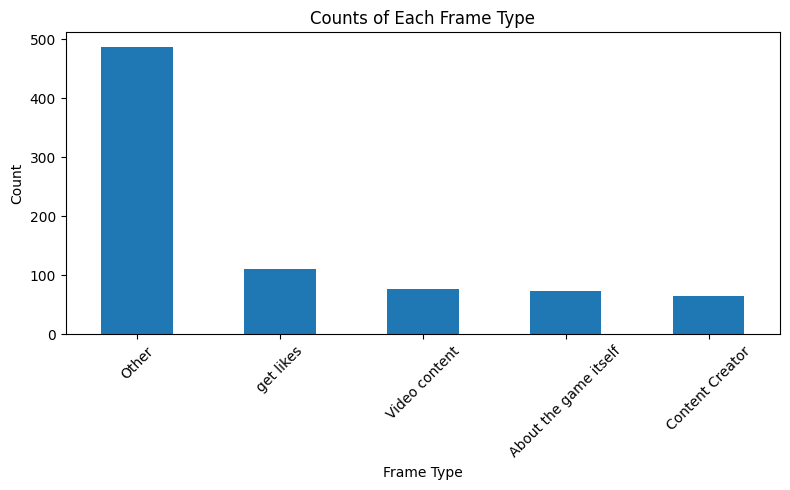

In [ ]:
comment_sorted1_copy['Frame'] = comment_sorted1_copy['Frame'].str.split('\n').str[0]
comment_sorted1_copy['Frame'] = comment_sorted1_copy['Frame'].replace({
    'About': 'About the game itself',
    'Get likes': 'get likes',
    'video content': 'Video content'
})

frame_counts = comment_sorted1_copy['Frame'].value_counts()

plt.figure(figsize=(8, 5))
frame_counts.plot(kind='bar')

plt.title("Counts of Each Frame Type")
plt.xlabel("Frame Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
creator = comment_sorted1_copy[comment_sorted1_copy['Frame'] == 'Content Creator']
creator.head(10)


In [ ]:
video_content = comment_sorted1_copy[comment_sorted1_copy['Frame'] == 'Video content']
video_content.head(10)


In [ ]:
game = comment_sorted1_copy[comment_sorted1_copy['Frame'] == 'About the game itself']
game.head(10)

Actually "About the game itself" is all about content creator and the video content. Looking at these examples, it's kinda hard to seperate them. But what we're sure is that there's a lack of comments talking about the techniques of Minecraft itself. Probably because this game is already familiar by majority. So the focus is more lean toward the video and content.

In [ ]:
df_content = comment_sorted1_copy[comment_sorted1_copy['Frame'].isin([
    'About the game itself', 'Content Creator', 'Video content'
])]


In [ ]:
df_content

,id,text,likes,Frame
655,UgyZhhffamrIwhNvQQ94AaABAg,Who noticed JJ was in creative mode he could g...,95,Video content
776,Ugx3xtbxa-ghyxEl5hd4AaABAg,Best Minecraft YouTuber Ever!!! 🏆🏆🏆,74,Content Creator
768,Ugxjv6I5QCqoIKuunnZ4AaABAg,Your videos are the best I promise I am always...,58,Content Creator
786,Ugw3_xzgMDNdxggaqF54AaABAg,Who loves Maizen’s Minecraft videos and how th...,53,Content Creator
758,UgxcGaK2sMZhlE8wjpp4AaABAg,"Hi maizen, luv u and ur videos sm!",52,Content Creator
...,...,...,...,...
25,UgxjbJkL-hTHqF50zmN4AaABAg,0:08 JJ is in creative 😅😅😅😅,0,Video content
765,UgylhuZxpgzEbF7m1Ex4AaABAg,Love this video less go diamond,0,Video content
260,UgzJy8zoz1bbB5pp7vl4AaABAg,Maizen yutuber the best,0,Content Creator
263,UgyR9MSab-j8l2mMLwp4AaABAg,Aku suka banget JJ,0,Content Creator


In [ ]:
!pip install wordcloud

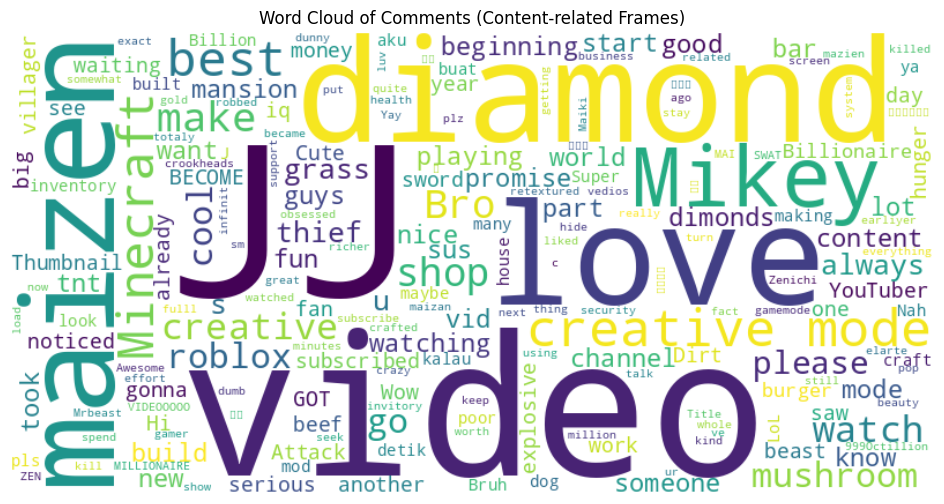

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = ' '.join(df_content['text'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Comments (Content-related Frames)")
plt.show()


In [ ]:
# Few-shot examples for different frames
examples = [
    {
        "frame": "Positive",
        "text": "I love this video."
    },
    {
        "frame": "Negative",
        "text": "This video is boring" or "I'm so disappointed"
    }]

# Define the example template
example_template = """Frame: {frame}
Text: {text}
"""

# Create a Few-Shot Prompt Template for classification
few_shot_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=PromptTemplate(input_variables=["frame", "text"], template=example_template),
    prefix="Below are examples of how different types of comments are defined.",
    suffix="Classify the following youtube comments into one of the 2 types: Positive and Negative.\nDescription: {description}\nFrame:",
    input_variables=["description"]
)

#please note here I changed the suffix for the new task
# Initialize OpenAI LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, openai_api_key=DEVELOPER_KEY)

# Create a LangChain pipeline
chain = LLMChain(prompt=few_shot_prompt, llm=llm)

In [ ]:
tqdm.pandas()  # Enable progress bar
df_content["Frame"] = df_content["text"].progress_apply(lambda x: chain.run(description=x))

100%|██████████| 215/215 [01:49<00:00,  1.96it/s]
<ipython-input-98-1e1bd9951309>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content["Frame"] = df_content["text"].progress_apply(lambda x: chain.run(description=x))


In [ ]:
df_content

<ipython-input-101-efc89bfabb69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['Frame'] = df_content['Frame'].str.split('\n').str[0]


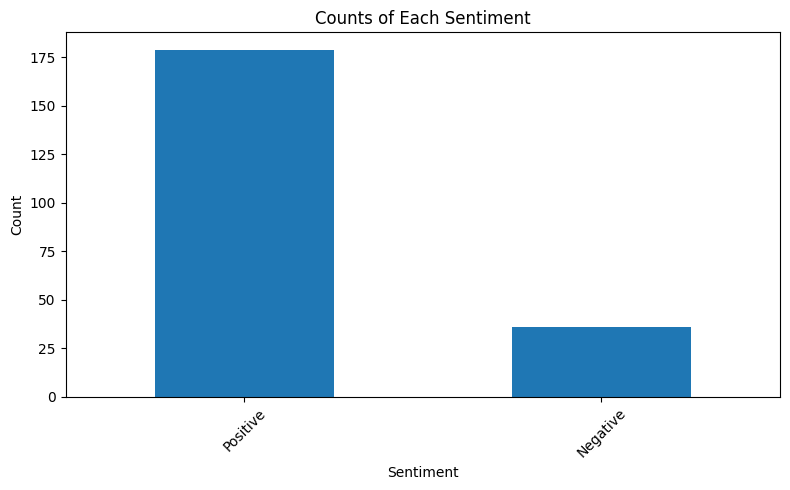

In [ ]:
df_content['Frame'] = df_content['Frame'].str.split('\n').str[0]
frame_counts = df_content['Frame'].value_counts()

plt.figure(figsize=(8, 5))
frame_counts.plot(kind='bar')

plt.title("Counts of Each Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
Negative = df_content[df_content['Frame'] == 'Negative']

In [ ]:
Negative

,id,text,likes,Frame
644,UgwNqrsZnBIdIfa5wn14AaABAg,JJ: We can't stay like this!,3,Negative
183,UgxSa8ACzGdXvKt7Fyh4AaABAg,At the start why does jj have no health and hu...,2,Negative
65,UgwxmEiBdDdYGcLg6Pp4AaABAg,"12:24 the ""explosive mushrooms"" are just retex...",2,Negative
467,UgwVhpjvuOWTqhFAdTB4AaABAg,Are you serious gamemode c get from invitory,2,Negative
518,UgymXL77VZl21tI3zmF4AaABAg,Mikey wants to kill someone using mushrooms th...,1,Negative
649,UgxwHoc-qTcpN8V3_eR4AaABAg,the thief already killed him,1,Negative
536,Ugyvo7UuTWrWkQRNq2Z4AaABAg,"jj was being dumb,he should have crafted a dia...",1,Negative
673,UgxWwFymWQQ1yA1aSgd4AaABAg,Dirt,1,Negative
50,UgxnKBJh6LECg-yVmNN4AaABAg,i not love to took diamons,1,Negative
441,Ugz_ZVpRY5aN-WXqksF4AaABAg,The Billionaire ate a burger instead of an exp...,1,Negative


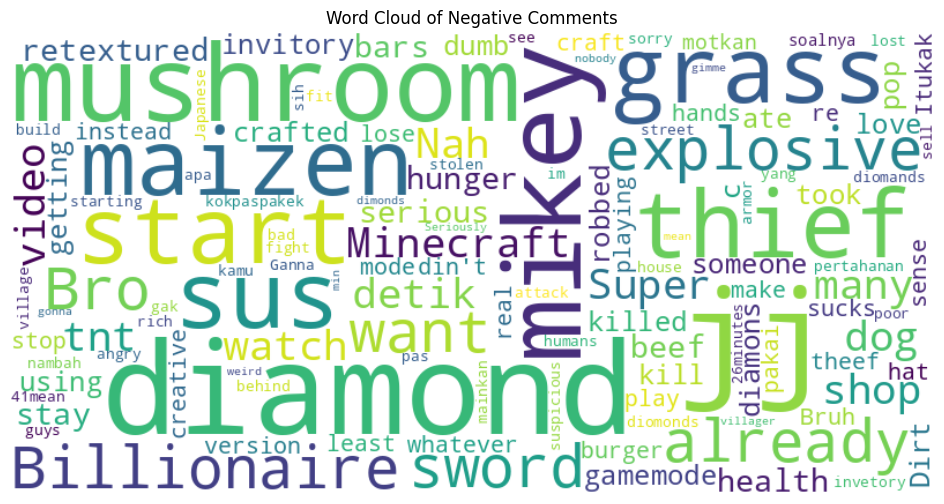

In [ ]:
text_data = ' '.join(Negative['text'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Negative Comments")
plt.show()


Even if the negative comments, they are all about the video content, especially about why the charaters in the video do something.

In [ ]:
Negative.to_csv('Negative.csv', index=False)

In [ ]:
comment_sorted1_copy.to_csv('comment_sorted1_copy.csv', index=False)